## Note

Consider change the value (points placed) to be $\frac{value^a}{2n}$ for a > 1 or $\frac{b^{value}}{2n}$ for b > 1, rewarding good explorations much more.

If place a point at somewhere will cause collinear triple(s), let that action be invalid. Then, exploring other actions. Terminating condition: adding any point will cause collinear triple(s).

How is policy calculated?

## Changes in 06_2

k points already placed. n by n grid.

1. Modified the terminal condition: attaining complete set, adding any point will cause collinear triple(s). The following items are changed:
   * `N3il.get_valid_moves`: In addition to get empty spots, we get all empty spots which will not cause collinear triples. Need to call `are_collinear`:

$$
\binom{k}{2} (n^2-k)
$$ 
times

## Next optimization

only consider a subset of parent node valid moves for efficiency.

In [8]:
import numpy as np
print(np.__version__)
import math
from itertools import combinations

import torch
print(torch.__version__)

torch.cuda.is_available()

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

import matplotlib.pyplot as plt

from tqdm import trange

import random

1.26.4
1.12.1


In [30]:
def are_collinear(p1, p2, p3):
  """Returns True if the three points are collinear."""
  """Adapt from https://github.com/kitft/funsearch"""
  x1, y1 = p1
  x2, y2 = p2
  x3, y3 = p3
  return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

class N3il:  # Class for the No-Three-In-Line problem
    def __init__(self, grid_size):
        self.row_count = grid_size[0]
        self.column_count = grid_size[1]
        self.pts_upper_bound = np.min(grid_size)
        self.action_size = self.row_count * self.column_count

    def get_initial_state(self):
        # Return a grid of zeros representing an empty board
        return np.zeros((self.row_count, self.column_count))

    def get_next_state(self, state, action):
        # Place a point at the specified action (row-major order)
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = 1
        return state

    def get_valid_moves(self, state):
        """
        Return a flattened array where 1 indicates a valid move (empty and no collinearity),
        and 0 indicates an invalid move.
        """
        valid_mask = np.zeros((self.row_count, self.column_count), dtype=np.uint8)  # start with all invalid
        coords = np.argwhere(state == 1)
        existing_pairs = list(combinations(coords, 2))

        for i in range(self.row_count):
            for j in range(self.column_count):
                if state[i, j] != 0:
                    continue
                candidate = (i, j)
                if any(are_collinear(p1, p2, candidate) for p1, p2 in existing_pairs):
                    continue
                valid_mask[i, j] = 1  # 1 means valid

        return valid_mask.reshape(-1)

    def check_collinear(self, state, action=None):
        # Check how many new collinear triples are formed by adding a new point

        if action is None:
            state_next = state
        else:
            row = action // self.column_count
            column = action % self.column_count
            state_next = state.copy()
            state_next[row, column] = 1

        coords = np.argwhere(state_next == 1)
        triples = list(combinations(coords, 3))

        number_of_collinear_triples = 0
        for triple in triples:
            if are_collinear(triple[0], triple[1], triple[2]):
                number_of_collinear_triples += 1

        return number_of_collinear_triples

    def get_value_and_terminated(self, state, valid_moves):
        # Return total number of points and whether a terminal condition is met
        if np.sum(valid_moves) > 0:
            return 0, False
        value = np.sum(state.reshape(-1) == 1) / self.pts_upper_bound # Normalization
        return value, True
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

    def display_state(self, state, action_prob=None):
        """
        Display the current grid configuration using matplotlib.
        Points are drawn where the state equals 1.
        The origin (0, 0) is located at the bottom-left.
        If action_prob is provided (1D array), it is reshaped and overlaid as a heatmap.
        """
        plt.figure(figsize=(6, 6))

        if action_prob is not None:
            assert action_prob.shape[0] == self.row_count * self.column_count, \
                f"Expected length {self.row_count * self.column_count}, got {len(action_prob)}"
            action_prob_2d = action_prob.reshape((self.row_count, self.column_count))
            flipped_probs = np.flipud(action_prob_2d)
            plt.imshow(
                flipped_probs,
                cmap='Reds',
                alpha=0.6,
                extent=[-0.5, self.column_count - 0.5, -0.5, self.row_count - 0.5],
                origin='lower',
                vmin=0, vmax=np.max(action_prob) if np.max(action_prob) > 0 else 1e-5
            )
            plt.colorbar(label="Action Probability", shrink=0.8)

        # Get the coordinates of placed points
        y_coords, x_coords = np.nonzero(state)
        flipped_y = self.row_count - 1 - y_coords

        plt.scatter(x_coords, flipped_y, s=100, c='blue', label='Placed Points')

        plt.grid(True)
        plt.xticks(range(self.column_count))
        plt.yticks(range(self.row_count))
        plt.xlim(-0.5, self.column_count - 0.5)
        plt.ylim(-0.5, self.row_count - 0.5)
        plt.gca().set_aspect('equal')
        plt.title("No-Three-In-Line Grid with Action Probabilities" if action_prob is not None else "No-Three-In-Line Grid")
        if len(x_coords) > 0:
            plt.legend()
        plt.show()

In [10]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        self.device = device
        self.startBlock = nn.Sequential(
            nn.Conv2d(2, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )

        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

PUCT Formula:

$$
U(s, a) = Q(s, a) + c_{\text{puct}} \cdot P(s, a) \cdot \frac{\sqrt{\sum_b N(s, b)}}{1 + N(s, a)}
$$

| Parameter / Function    | Meaning                                                                               |
| -------------------- | ------------------------------------------------------------------------------------- |
| $U(s, a)$          | **PUCT score** for selecting action $a$ in state $s$                              |
| $Q(s, a)$          | **Mean value** (estimated reward) of action $a$ from state $s$                    |
| $c_{\text{puct}}$ | **Exploration constant** controls the level of exploration vs exploitation           |
| $P(s, a)$          | **Prior probability** of taking action $a$ in state $s$ (from the policy network) |
| $N(s, b)$          | **Visit count** of action $b$ in state $s$                                        |
| $\sum_b N(s, b)$  | **Total visit count** of all actions $b$ from state $s$                           |


In [11]:
'''
Adapt from
foersterrobert/AlphaZeroFromScratch
'''

class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []
        self.valid_moves = game.get_valid_moves(state)

        self.visit_count = 0
        self.value_sum = 0

    def is_fully_expanded(self):
        return len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        
        return best_child
    
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1)/2 
        # Think about: Since value_sum could be negative, we do this to make q_value be a probability
        # We do "1 - " because we want to put opponent in a bad situation
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

        return child

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
    
    @torch.no_grad() # We don't use this for training   
    def search(self, state):
        # define root
        root = Node(self.game, self.args, state)

        for search in range(self.args['num_searches']):
            node = root

            # selection
            while node.is_fully_expanded():
                node = node.select()

            # has_collinear = self.game.check_collinear(node.state, node.action_taken)
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.valid_moves)

            if not is_terminal: # If no collinear triples
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                # valid_moves = self.game.get_valid_moves(node.state)
                policy *= node.valid_moves
                policy /= np.sum(policy) 
                
                value = value.item()
                node = node.expand(policy)

            node.backpropagate(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
            
            # expansion
            # simulation
            # backpropagation

        # return visit_counts

In [12]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
        
    def selfPlay(self):
        memory = []
        state = self.game.get_initial_state()
        
        while True:
            action_probs = self.mcts.search(state)
            
            memory.append((state, action_probs))
            
            action = np.random.choice(self.game.action_size, p=action_probs)
            
            state = self.game.get_next_state(state, action)

            valid_moves = self.game.get_valid_moves(state)
            # has_collinear = self.game.check_collinear(node.state, node.action_taken)
            value, is_terminal = self.game.get_value_and_terminated(state, valid_moves)
            
            if is_terminal:
                returnMemory = []
                for hist_state, hist_action_probs in memory:
                    hist_outcome = value
                    returnMemory.append((
                        self.game.get_encoded_state(hist_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
                
    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx : batchIdx + self.args['batch_size']]
            if not sample:
                continue  # skip empty batch
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            self.optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            self.optimizer.step() # change to self.optimizer
    
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
                
            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            if (iteration + 1) % self.args['save_interval'] == 0:
                torch.save(self.model.state_dict(), f"{self.args['weight_file_name']}_model_{iteration}.pt")
                torch.save(self.optimizer.state_dict(), f"{self.args['weight_file_name']}_optimizer_{iteration}.pt")

In [13]:
from torchsummary import summary

n = 5

n3il_test = N3il(grid_size=(n,n))

args = {
    'C': 1.41,
    'num_searches': 1000
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU:", torch.cuda.is_available())
model_test = ResNet(n3il_test, 4, 64, device)
summary(model_test, input_size=(2, n, n))

GPU: False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 5, 5]           1,216
       BatchNorm2d-2             [-1, 64, 5, 5]             128
              ReLU-3             [-1, 64, 5, 5]               0
            Conv2d-4             [-1, 64, 5, 5]          36,928
       BatchNorm2d-5             [-1, 64, 5, 5]             128
            Conv2d-6             [-1, 64, 5, 5]          36,928
       BatchNorm2d-7             [-1, 64, 5, 5]             128
          ResBlock-8             [-1, 64, 5, 5]               0
            Conv2d-9             [-1, 64, 5, 5]          36,928
      BatchNorm2d-10             [-1, 64, 5, 5]             128
           Conv2d-11             [-1, 64, 5, 5]          36,928
      BatchNorm2d-12             [-1, 64, 5, 5]             128
         ResBlock-13             [-1, 64, 5, 5]               0
           Conv2d-14        

In [14]:
n = 5

n3il = N3il(grid_size=(n,n))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(n3il, 4, 64, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'save_interval': 1,
    'weight_file_name': "n3il_6_2_attempt_1_5by5_iter_3_selfplay_500"
}

alphaZero = AlphaZero(model, optimizer, n3il, args)
alphaZero.learn()

100%|██████████| 4/4 [00:22<00:00,  5.53s/it]


0.999798595905304
[[0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
tensor([[[[1., 0., 1., 0., 1.],
          [0., 1., 0., 1., 1.],
          [0., 1., 1., 1., 0.],
          [1., 0., 1., 1., 1.],
          [1., 1., 1., 1., 0.]],

         [[0., 1., 0., 1., 0.],
          [1., 0., 1., 0., 0.],
          [1., 0., 0., 0., 1.],
          [0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1.]]]])
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.47700417 0.        ]
 [0.         0.         0.         0.5229958  0.        ]]


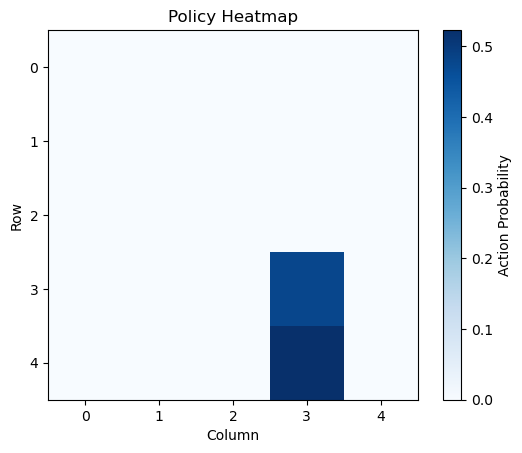

In [37]:
n = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n3il_result = N3il(grid_size=(n,n))

state = np.array([
    [0., 1., 0., 1, 0],
    [1., 0., 1., 0, 0],
    [1., 0., 0., 0, 1],
    [0., 1., 0., 0, 0],
    [0., 0., 0., 0, 1]
    ])

valid_moves = n3il_result.get_valid_moves(state)

encoded_state = n3il_result.get_encoded_state(state)
tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model_result = ResNet(n3il_result, 4, 64, device=device)
model_result.load_state_dict(torch.load(f"{args['weight_file_name']}_model_2.pt", map_location=device))
model_result.eval()

policy, value = model_result(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()
policy *= valid_moves
policy /= np.sum(policy) 
policy_2d = policy.reshape(n, n)

print(value)

print(state)
print(tensor_state)
print(policy_2d)

plt.imshow(policy_2d, cmap='Blues', interpolation='nearest')
plt.colorbar(label='Action Probability')
plt.title("Policy Heatmap")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

---------------------------
Number of points: 0
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


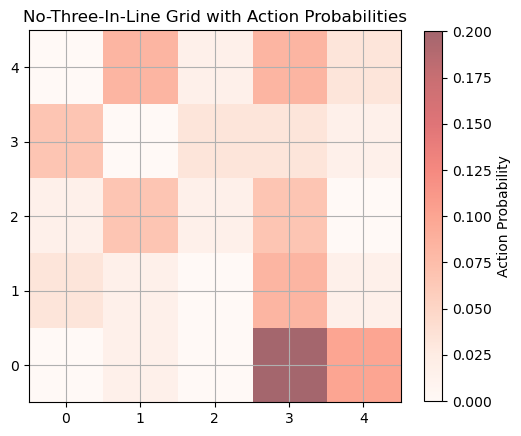

---------------------------
Number of points: 1
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


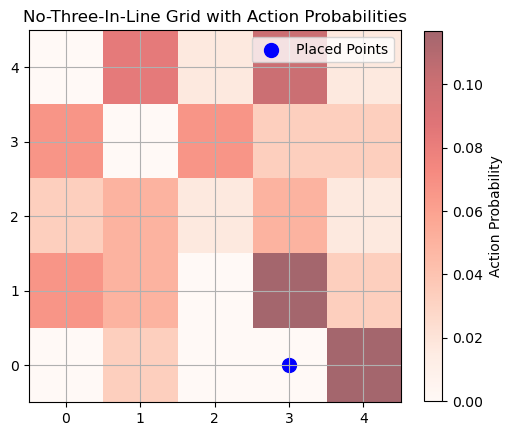

---------------------------
Number of points: 2
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


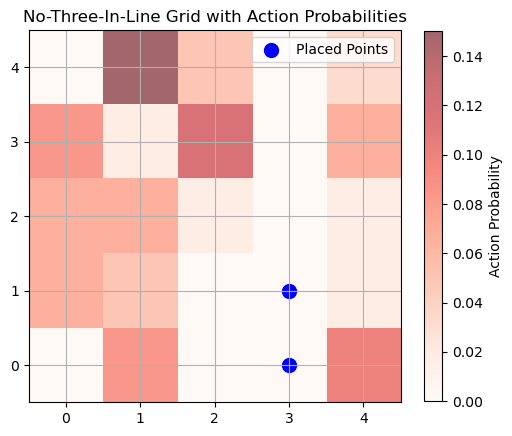

---------------------------
Number of points: 3
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


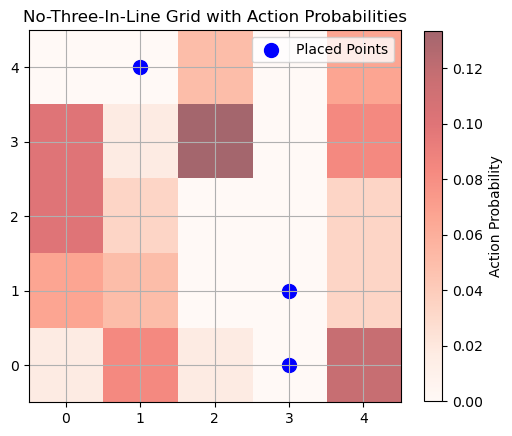

---------------------------
Number of points: 4
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


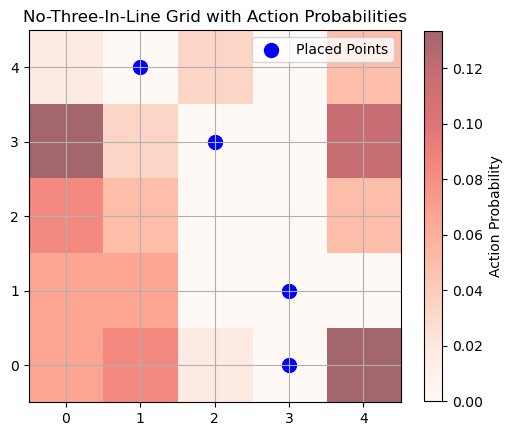

---------------------------
Number of points: 5
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


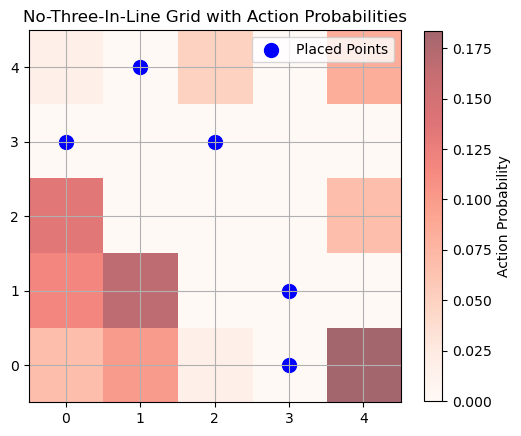

---------------------------
Number of points: 6
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


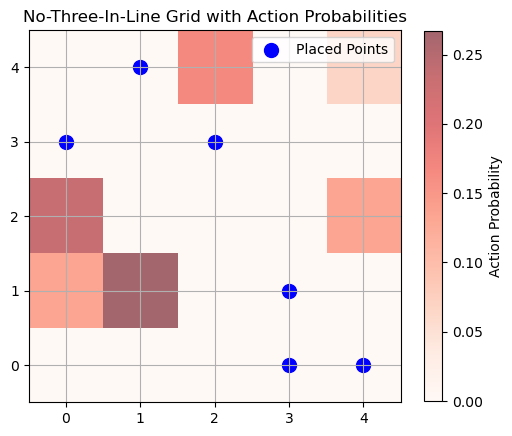

---------------------------
Number of points: 7
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


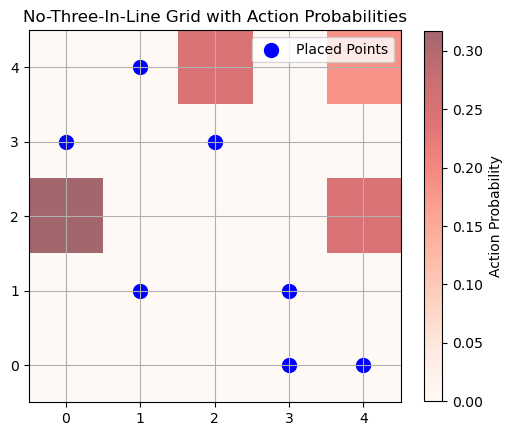

---------------------------
Number of points: 8
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


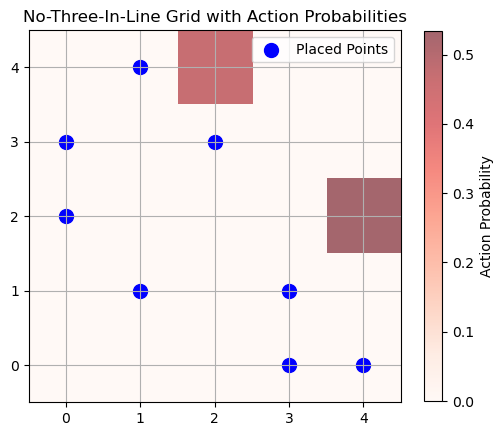

---------------------------
Number of points: 9
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


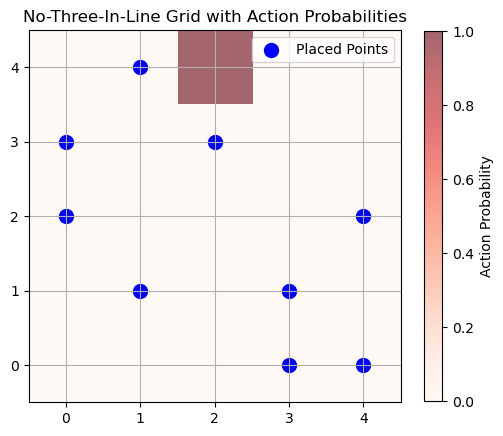

---------------------------
Number of points: 10
[[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


/var/folders/ts/3flnl5q17n9040phm1x109tc0000gn/T/ipykernel_10980/1849474143.py:101: RuntimeWarning: invalid value encountered in divide
  action_probs /= np.sum(action_probs)


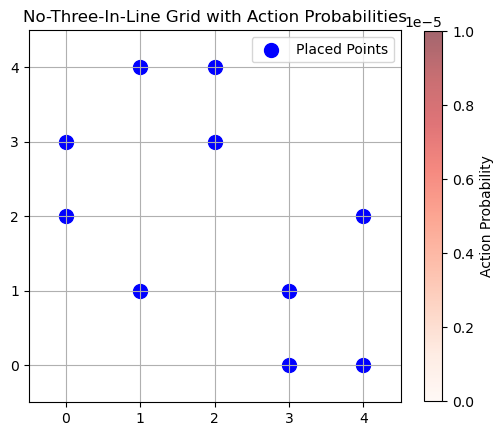

*******************************************************************
Trial Terminated with 10 points. Final valid configuration:
[[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


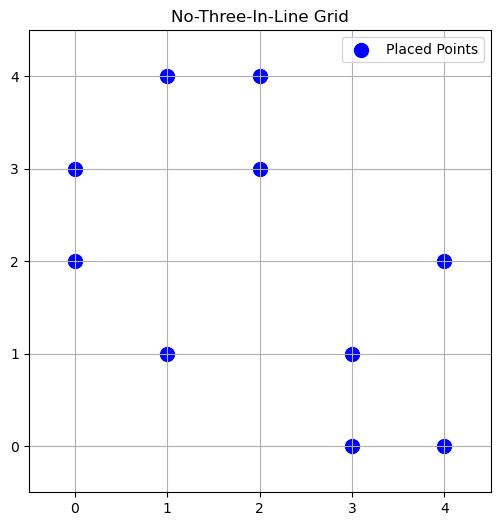

The point you give causes 4 triples of 3 points collinear:
[[1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 1.]]


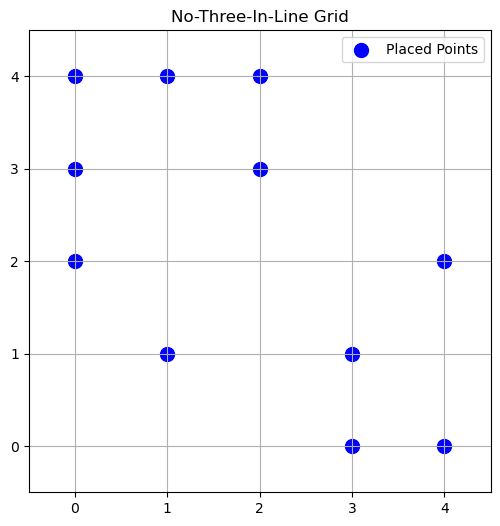

In [38]:
n3il = N3il((n,n))

mcts_result = MCTS(n3il, args, model_result)

state = n3il.get_initial_state()
num_of_points = 0

while True:
    print("---------------------------")
    print(f"Number of points: {num_of_points}")
    print(state)
    # n3il.display_state(state)

    mcts_probs = mcts_result.search(state)
    action = np.argmax(mcts_probs)
    n3il.display_state(state, mcts_probs)

    '''
    valid_moves = n3il.get_valid_moves(state)
    list_valid_moves = [i for i in range(n3il.action_size) if valid_moves[i] == 1]
    print("valid moves: ", list_valid_moves)
    
    action = int(input("Please give a point: "))
    if action not in list_valid_moves:
        print("This spot is occupied. Action is not valid.")
        continue
    '''

    n_of_collinear_triples = n3il.check_collinear(state, action)

    if n_of_collinear_triples > 0:
        # value, _ = n3il.get_value_and_terminated(state)
        print("*******************************************************************")
        print(f"Trial Terminated with {num_of_points} points. Final valid configuration:")
        print(state)
        n3il.display_state(state)
        print(f"The point you give causes {n_of_collinear_triples} triples of 3 points collinear:")
        print(n3il.get_next_state(state, action))
        n3il.display_state(n3il.get_next_state(state, action))

        break
    
    num_of_points += 1
    state = n3il.get_next_state(state, action)